<h1>Forecasting Sales with FbProphet</h1>
<br/>
2021-10-04

Install Facebook Prophet

In [10]:
#from IPython.display import clear_output

#!pip install pystan==2.19.1.1
#! pip install fbprophet

#clear_output()

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings

warnings.filterwarnings('ignore')

import fbprophet 
from fbprophet import Prophet as proph
from fbprophet.plot import add_changepoints_to_plot


In [2]:
train = pd.read_csv(os.path.split(os.getcwd())[0] +'/sales-forecasting-womart-store/TRAIN.csv')
train.head(5)

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [22]:
#aggregate sales and plot (what we will try to forecast initially)
train_sales_agg = train.groupby(by=['Date', 'Holiday'], as_index=False, sort=True)['Sales'].agg('sum')
#rename columns (requirement for fbprophet)
train_sales_agg.columns=['ds', 'Holiday', 'y']
#convert date column to datetime 
train_sales_agg = train_sales_agg.assign(ds=lambda df: pd.to_datetime(df['ds'], format='%Y-%m-%d'))
#train_sales_agg['y'] = np.log(train_sales_agg['y'])
train_sales_agg.head(5)

,ds,Holiday,y
0,2018-01-01,1,15345484.5
1,2018-01-02,0,19592415.0
2,2018-01-03,0,18652527.0
3,2018-01-04,0,19956267.0
4,2018-01-05,0,22902651.0


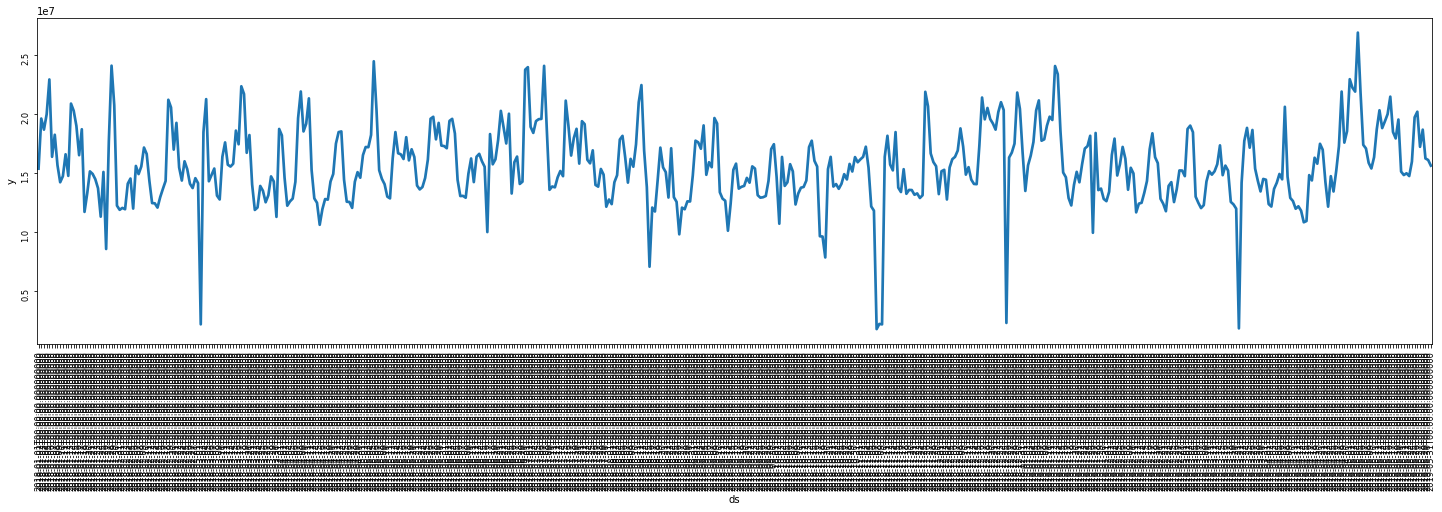

In [4]:
#plot sales time series
fig, ax = plt.subplots(figsize=(25,6));
sns.pointplot(x='ds', y='y', data=train_sales_agg, ci=None, markers='', ax=ax);
ax.tick_params(rotation=90, labelsize='small');
plt.show()

In [23]:
n = train_sales_agg.shape[0]
train_size = 0.7
training_set = train_sales_agg.iloc[:int(n * train_size)]
validation_set = train_sales_agg.iloc[int(n * train_size):]
print(f'train set size: {len(train_sales_agg)}')
print(f'test set size: {len(validation_set)}')


train set size: 516
test set size: 155


In [25]:
training_set

,ds,Holiday,y
0,2018-01-01,1,15345484.5
1,2018-01-02,0,19592415.0
2,2018-01-03,0,18652527.0
3,2018-01-04,0,19956267.0
4,2018-01-05,0,22902651.0
...,...,...,...
356,2018-12-23,0,20975379.0
357,2018-12-24,1,20311470.9
358,2018-12-25,1,2282733.0
359,2018-12-26,0,16289970.0


Text(0.5, 1.0, 'Training data with model forecast')

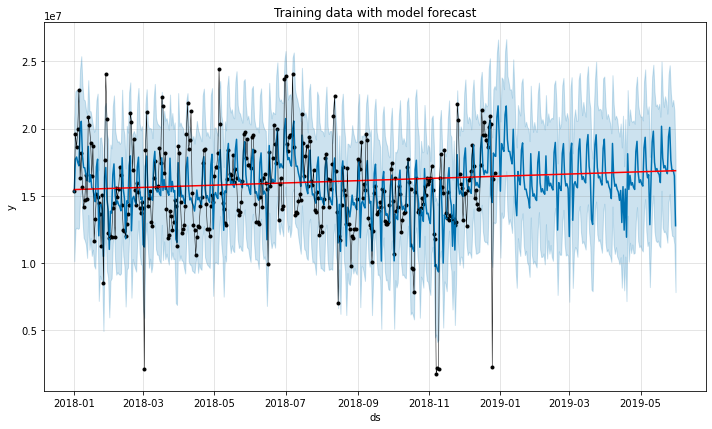

In [35]:
interval=0.95

days_to_predict=155
model = proph(interval_width=interval, daily_seasonality=False, seasonality_mode='additive', weekly_seasonality=True, yearly_seasonality=True)
model.add_regressor('Holiday', mode='multiplicative')
model.fit(training_set)
future = model.make_future_dataframe(periods=days_to_predict, freq='D') #create new dataframe
future['Holiday'] = train_sales_agg['Holiday'].dropna()

forecast = model.predict(future) #future predictions

#to-do:
#add holidays
#add regressors
#calculate best parameters
#log-transform y (predictions are worse)

# Plot the model and forecast
fig = model.plot(forecast, uncertainty=True)
a = add_changepoints_to_plot(fig.gca(), model, forecast)
plt.plot(training_set['ds'], training_set['y'], color='black',  label='', linewidth=0.5)
plt.title('Training data with model forecast')
#plt.legend();


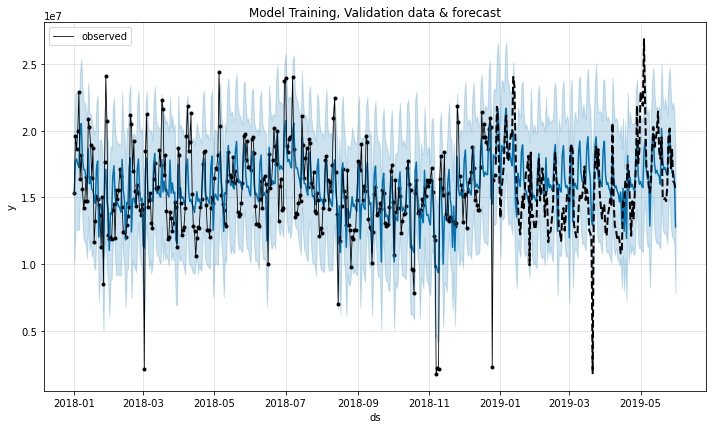

In [36]:
# Make predictions and compare to test data
y_pred = model.predict(validation_set)
training_test_results = pd.concat([forecast, y_pred])

# Plot the model, forecast, and actual (test) data
model.plot(forecast, uncertainty=True)
plt.plot(training_set['ds'], training_set['y'], color='black',  label='observed', linewidth=0.8)
plt.plot(validation_set['ds'], validation_set['y'], color='black', label='',linewidth=2, linestyle='--')
#plt.plot(reduced_dates_train['ds'], reduced_dates_train['y'], color='black',  label='', linewidth=0.5)
plt.title(f'Model Training, Validation data & forecast')
plt.legend();

plt.show()

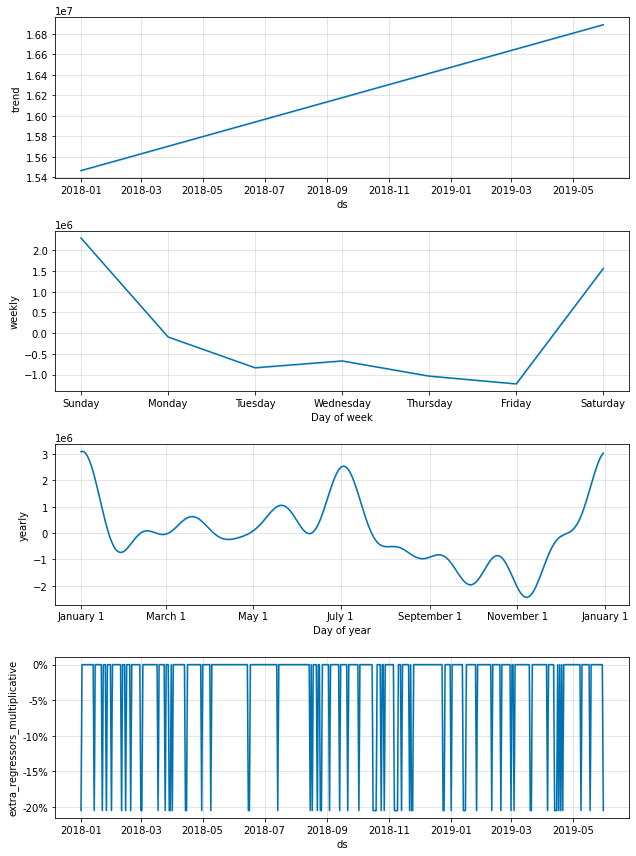

In [34]:
fig2=model.plot_components(forecast)


In [75]:
test = test.assign(ds=lambda df: pd.to_datetime(df['Date'], format='%Y-%m-%d'))
test.head(4)

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,ds
0,T1188341,171,S4,L2,R3,2019-06-01,0,No,2019-06-01
1,T1188342,172,S1,L1,R1,2019-06-01,0,No,2019-06-01
2,T1188343,173,S4,L2,R1,2019-06-01,0,No,2019-06-01
3,T1188344,174,S1,L1,R4,2019-06-01,0,No,2019-06-01


In [64]:
#dataframe for final predictions
final_test = pd.read_csv(os.path.split(os.getcwd())[0] +'/sales-forecasting-womart-store/TEST_FINAL.csv')
final_test.head(5)

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
0,T1188341,171,S4,L2,R3,2019-06-01,0,No
1,T1188342,172,S1,L1,R1,2019-06-01,0,No
2,T1188343,173,S4,L2,R1,2019-06-01,0,No
3,T1188344,174,S1,L1,R4,2019-06-01,0,No
4,T1188345,170,S1,L1,R2,2019-06-01,0,No
